# Finding the Happiness Factor
The following will be a tutorial on how to use data from different data sources and utilize the datascience pipeline to collect and curate, manage and represent, explore, test your hypothesis on, and communicate the insights found in 2 different sets of data. Hopefully by the end of this tutorial you will learn how to leverage this pipeline to find unique patterns and correlations. For the following notebook, we be exploring the World Happiness Report for 2021 and the World Development Indicators to determine what development factors best correspond with increased happiness across the globe. We hope you enjoy this tutorial and maybe, just maybe, even figure out the key to world happiness. (No promises).
- Project by Victor Novichkov, Jacob Livchitz

### Downloading the datasets
- Need to have Python installed
- Recommended to install the kaggle pip library
    - ```pip install kaggle```
- Copy the commands listed under the datasets

### Datasets Used
[World Development Indicators - World Bank](https://datacatalog.worldbank.org/dataset/world-development-indicators) (~200MB at time of writing)
- How to download
    - Go to the **Data & Resources** tab
    - Download the **CSV**

[World Happiness Report 2021 - Ajaypal Singh](https://www.kaggle.com/ajaypalsinghlo/world-happiness-report-2021) (155KB at time of writing)
- How to download
    - ```kaggle datasets download -d ajaypalsinghlo/world-happiness-report-2021```


## Looking at and Importing the Data 

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

whr_path = './world-happiness-index/whr.csv'
wdi_path = './world-development-index/WDIData_trimmed_n.csv'

whr_data = pd.read_csv(whr_path)
simplified_whr_data = whr_data[['Country Name', 'Life Ladder', 'Year']] # get just the name / score / and year

countries = pd.unique(simplified_whr_data['Country Name'])
print("Total Countries with Indices: {}".format(len(countries)))

wdi_data = pd.read_csv(wdi_path, index_col=0)

Total Countries with Indices: 166


In [58]:
# Look at the overall Happiness Indicator Data
print(simplified_whr_data)

# Look at a specific country, what does the data look like
print("\nCountry Specific Data: United States")
print(simplified_whr_data[simplified_whr_data['Country Name'] == 'United States'])

# How many years have Life Ladder (Happiness Scores) been collected
print("\nTotal Years of Happiness Scores: {} (since 2005)".format(len(pd.unique(simplified_whr_data['Year']))))

     Country Name  Life Ladder  Year
0     Afghanistan        3.724  2008
1     Afghanistan        4.402  2009
2     Afghanistan        4.758  2010
3     Afghanistan        3.832  2011
4     Afghanistan        3.783  2012
...           ...          ...   ...
1944     Zimbabwe        3.735  2016
1945     Zimbabwe        3.638  2017
1946     Zimbabwe        3.616  2018
1947     Zimbabwe        2.694  2019
1948     Zimbabwe        3.160  2020

[1949 rows x 3 columns]

Country Specific Data: United States
       Country Name  Life Ladder  Year
1836  United States        7.182  2006
1837  United States        7.513  2007
1838  United States        7.280  2008
1839  United States        7.158  2009
1840  United States        7.164  2010
1841  United States        7.115  2011
1842  United States        7.026  2012
1843  United States        7.249  2013
1844  United States        7.151  2014
1845  United States        6.864  2015
1846  United States        6.804  2016
1847  United States      

## Dealing with Too Much Data
Although the World Bank dataset is amazing, its size is a bit too much for Github to even accept. In order to be able to collaborate we had to cut how much data we were working with. Luckily, there were a couple methods we could use to cut our dataset in half without drastically influencing our analysis
- Get rid of countries in the World Development Index data that don't have corresponding happiness indices
- Get rid of majority NaN/Null datapoints (we won't be looking at them in our analysis)
    - Note: The World Happiness Index started in 2012, which means most of the data in the World Development Index going back to 1960 isn't entirely relevant. As a result we can look for rows that have at least 20 non null entries (1990-2020).

```python
# Creating the truncated dataset
wdi_data = pd.read_csv(wdi_path)

# First by removing countries that don't have indices
boolean_mask = wdi_data['Country Name'].isin(countries)
wdi_cleaned = wdi_data[boolean_mask]
print("% of dataset trimmed: {0:.4f}".format((1 - (len(wdi_cleaned)/len(wdi_data)))*100))

# Remove all data from 1960 - 1999 (Most of the data from before the the Happiness Index even existed)
wdi_pre_drop = len(wdi_cleaned.columns)
wdi_cleaned.drop(axis=1, labels=wdi_cleaned.columns[4:44], inplace=True)
print("% of dataset trimmed: {0:.4f}".format((1 - (wdi_pre_drop/len(wdi_cleaned.columns)))*100))

# Get rid of all rows that have less than 8 datapoints over the time period from (2000-2020)
pre_dropna = len(wdi_cleaned)
wdi_cleaned.dropna(axis=0, thresh=8, inplace=True)
print("% of dataset trimmed: {0:.4f}".format((1 - (len(wdi_cleaned)/pre_dropna)) * 100))

# wdi_cleaned.to_csv('./world-development-index/WDIData_trimmed_n.csv')
```

Since the original dataset could not be uploaded. We can't show the comparison live

But we were able to trim 44.7% of the data just by removing countries without Happiness Indices

And trim a further 45.45% of the data by removing the datapoints from (1960 - 1989), leaving only 1990-2020

And trim an additional 15.99% of the data, dropping our final file size to ~ 27 MB

In [59]:
sample_code = "EG.CFT.ACCS.ZS"

# Gets Country Name, Country Code, Year, Indicator Value, Score for a specific indicator
def getAllForIndicator(df, hi, indicator_code):
    
    countries = df[df['Indicator Code'] == indicator_code].copy()
    countries.drop(axis=1, labels=['Indicator Name', 'Indicator Code'], inplace=True)
    countries = pd.melt(countries, id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='indicator_value')
    countries = countries.astype({'Year': np.int64})

    return countries.merge(hi, how='inner', on=['Country Name', 'Year']).dropna()

getAllForIndicator(wdi_data, simplified_whr_data, sample_code)

,Country Name,Country Code,Year,indicator_value,Life Ladder
0,Australia,AUS,2005,100.00,7.341
1,Belgium,BEL,2005,100.00,7.262
2,Brazil,BRA,2005,91.04,6.637
3,Canada,CAN,2005,100.00,7.418
4,Czech Republic,CZE,2005,95.65,6.439
...,...,...,...,...,...
1231,Uruguay,URY,2016,97.97,6.171
1232,Uzbekistan,UZB,2016,92.10,5.893
1233,Vietnam,VNM,2016,66.92,5.062
1234,Zambia,ZMB,2016,16.43,4.348


The data processing for this dataset wasn't extremely complicated but required some manipulating to get it into a more workable form
- The code above gets alls the rows with the associated indicator (one of the World Bank's Development Indicators) and further removes unneeded data
- Melting is used to make the `Year` columns into row values instead, and then that row value is casted to an actual int rather than an object for ease of use
- The columnized year/indicator data is then merged with the happiness indicator data to add the happiness score as an additional column

# Analyzing the Data
### When you get any sort of chronological data, it is always a good idea to graph it vs time.
Since we are looking at a happiness score, we want to average out that score per year so that we can get a good estimate to see if the average happiness levels have gone up or down throughout the years. 

To do this we can use a violin plot. This will require us to segment our data by year so we create a new array for each year and append that years data into it. 

Once we are done we can graph our violin plot and see that the world has, on average, not gotten happier. It is also interesting to see that 2005 for whatever reason seems to have been the best year in the last decade.
- We attribute this increased Happiness Score to the fact that the World Happiness Report started in 2005 and that at first the number of participating countries was much smaller.

Violin Plot of Happiness Scores Over the 2005-2016


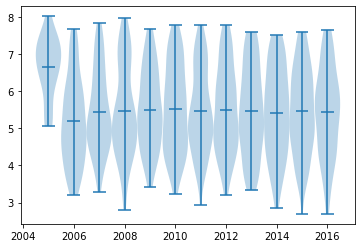

In [60]:
#Firstly, we will see if happiness has changed over time.
ipc_code = "EG.CFT.ACCS.ZS"
incomePerCap=getAllForIndicator(wdi_data, simplified_whr_data, ipc_code) # fetch data associated with the code
years=[]

# get a list of all the years
for x,row in incomePerCap.iterrows(): 
    years.append(row.Year)
years=list(set(years))
years.sort()

# break the data into groups according to the year
happy_per_year=[]
for yearIndex in years:
    currentYear=[]
    for x,row in incomePerCap.iterrows():
        if row.Year==yearIndex:
            currentYear.append(row['Life Ladder'])
    happy_per_year.append(currentYear)

#plot a violin plot of the happiness grouped
plt.violinplot(happy_per_year,years,widths=1,showmeans=True)
print("Violin Plot of Happiness Scores Over the 2005-2016")

## Dealing with NaN and Problems with Time Series
### Lots of NaNs
- An issue with our original truncation was that we didn't replace NaN data with actual values
- Now the initial approach would be something like, "Just fill it with zero values"
    - But this lends itself to some pretty significant issues

While an approached like:

```python
df.fillna(0)
```
May work in some cases. But in our dataset, especially if we look at year to year changes, a change from 0 to one of the indicator values like for example (# of tractors per square mile) would be significant enough to show a trend where there in reality shouldn't be one.

Which is why we chose to instead backfill the data (take the next valid observation to fill the gap), in order to insure that there wouldn't be as dramatic of a change between years or between countries as there would be if we just set everything to 0.

```python
df.fillna(axis=0, method='bfill')
```

### Problems with Time Series
It may seem counter intuitive, but in our analysis, having our indicator data be time dependent led to some issues during analysis
- While traditionally, most data is usually `Time vs. Your Dependent Variable`, in this case we are analyzing how certain indicators affect another indicator (the Life Ladder or Happiness Score)
- Which meant that, with the data being over time, there would be additional confounding variables that contribute to the Happiness Score or Indicators increase or decrease that is dependant on data we did not collect from the World Bank dataset.
    - Some examples could be: Global policy initatives, shifts in public thinking, sudden environmental changes (like for example COVID)
    - This could reverse some trends or cause other trends to appear when they shouldn't actually be there.

This issue is most evident when looking at a more narrow set of data, like a specific indicator's mean across countries over time, or a specific countries' indicators over time.

In order to combat this, rather than looking at all of our data over time, we instead look at a single year, and instead compare different countries.
- This serves to both remove any confounding variables that may change our indicators over time, and also make the data depend on the countries more, which is relevant to our analysis

 

In [61]:
# Overall
def getAllIndicators(df, hi):
    
    # drop any indicators that don't have enough data points and backfill the remaining indicators
    mean_data = df.dropna(axis=0, thresh=5).fillna(axis=0, method='bfill').groupby(by='Indicator Code').mean().transpose()

    # fixing the columns and data types for merging later
    mean_data = mean_data.rename_axis('index', axis='columns')
    mean_data = mean_data.reset_index(level=[0]).rename(columns={'index': 'Year'})
    mean_data = mean_data.astype({'Year': np.int64})

    # gets the happiness scores and gets the mean score per year
    mean_happiness_data = hi.groupby(by='Year').mean().reset_index(level=[0])

    # merge the indicator dataframe and the happiness score dataframe
    return mean_data.merge(mean_happiness_data, how='inner', on=['Year'])

print(getAllIndicators(wdi_data, simplified_whr_data).iloc[:,:5])

    Year  AG.AGR.TRAC.NO  AG.CON.FERT.PT.ZS  AG.CON.FERT.ZS  AG.LND.AGRI.K2
0   2005   251457.119245       1.484809e+03    2.823145e+02   294623.867393
1   2006   197358.215923       1.266296e+03    3.097155e+02   294975.193566
2   2007   163621.078574       1.457692e+03    2.746442e+02   294598.376283
3   2008    68444.614357       1.085124e+03    3.008969e+02   294146.248662
4   2009    60114.385301       1.016698e+03    1.766156e+02   293781.649849
5   2010        2.556754       4.004918e+02    1.898537e+02   293887.446312
6   2011        2.691892       4.697430e+02    2.271550e+02   302066.355862
7   2012        3.471752       4.641427e+02    2.172395e+02   301710.556628
8   2013        3.618624       4.086468e+02    2.220963e+02   301118.861193
9   2014        3.584634       5.271770e+02    2.006468e+02   301146.547428
10  2015        4.084381       8.148199e+02    1.913728e+02   299699.885690
11  2016       87.952085       8.511047e+02    1.862497e+02   299793.284069
12  2017    

### Analysis (Time Dependent Data)
- Just by looking at the above table, you can begin to see the issues that some of the data presents
- Mean Agricultural Machinery (AG.AGR.TRAC.NO), significantly decreased per year since 2005 to 2009, but those trends could be completely absent for some countries and unfortunately, by calcuting the mean across countries, countries with more significant statistics dramatically overwhelm countries with smaller statistics, which could misrepresent the data we are trying to analyze

By instead looking at 1 year chunks, we can see how Happiness Scores vary between countries and what factors contribute rather than indavertantely looking at how the Happiness Scores were affected by time.

In [1]:
# Gets the merged data of all indicators per country for a specific year
def getAllIndicatorsPerCountryForYear(df, hi, year):
    
    # pull relevant data out of the development indicator dataset
    mean_data = df[["Country Name", "Indicator Name", "Indicator Code", str(year)]]

    new_data_table = mean_data.pivot(index=['Indicator Name'],columns=['Country Name'], values=[str(year)]).T.dropna(axis=0, thresh=5).fillna(axis=0, method='bfill')
    mean_happiness_data = hi[hi['Year'] == year]

    return new_data_table.merge(mean_happiness_data, how='inner', on=['Country Name'])

# Plotting the heatmap for indicators for a specific year
def plotYearlyHeatmap(wdi_data, hi, year):

    # get the correlation matrix for the indicators per country for a year
    # .corr() returns a 2d matrix of Pearson's correlation coefficient using the Welfords algorithm
    corr_data = getAllIndicatorsPerCountryForYear(wdi_data, hi, year).corr()

    # get the index for the Happiness Score column
    hi_idx = corr_data.columns.get_loc('Life Ladder')
    plt.figure(figsize =(1,20))

    print('World Bank Indicators Correlation with Happiness Score for {} across all countries'.format(year))

    # Plot every 5 indicators (can't plot all of them since there are actually too many indicators to graph)
    sns.heatmap(corr_data.sort_values(by='Life Ladder', ascending=False).iloc[0:len(corr_data):5, hi_idx:hi_idx+1].dropna(), center = 0, cmap = 'coolwarm')
    plt.show()

# plot a 4 year period
plotYearlyHeatmap(wdi_data, simplified_whr_data, 2016)
plotYearlyHeatmap(wdi_data, simplified_whr_data, 2017)
plotYearlyHeatmap(wdi_data, simplified_whr_data, 2018)
plotYearlyHeatmap(wdi_data, simplified_whr_data, 2019)

NameError: name 'wdi_data' is not defined

### Looking at the Global Statistics for a 4 year Period (2016-2019)
- This period was chosen because of how recent it is to the present and that its analysis could give us insight into the state of the world today
- 2020 was not included because the 2020 year dataset was missing a lot of datapoints (the World Bank data may have not yet been compiled at the time of sourcing the data)

#### Some Interesting Results
- Education participation was correlated with higher scores
- Some byproducts of developed nations were attributed to higher scores like:
    1. Current health expenditure per capita, PPP (current international $) (2016)
    2. International tourism, number of departures (2016)
    3. High Technology Exports (current US$) (2018)
- Mortality Rates, Diseases, Foreign Aid, Lower education participation, unemployment were some of the biggest indicators of a lower Happiness Score


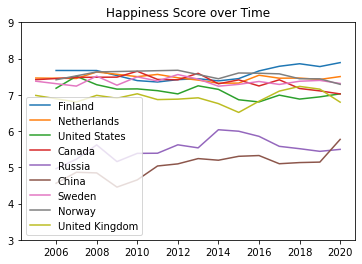

In [63]:
# Get all indicators over time for a specific country
def getAllIndicatorsForCountry(df, hi, country):

    # Get a specific countries' data, drop any NaN rows, backfill the remaining
    mean_data = df[df['Country Name'] == country].dropna(axis=0, thresh=5).fillna(axis=0, method='bfill').groupby(by='Indicator Name').mean().transpose()

    # Fix the indexing for merging later
    mean_data = mean_data.rename_axis('index', axis='columns')
    mean_data = mean_data.reset_index(level=[0]).rename(columns={'index': 'Year'})
    mean_data = mean_data.astype({'Year': np.int64})

    return mean_data.merge(hi[hi['Country Name'] == country].groupby(by='Year').mean(), how='inner', on=['Year'])

# Graph a list of countries' happiness scores over time on the same line plot
def plotCompareCountries(data, countries):
    # iterate through each country and plot the respective happiness score over time
    for country in countries:
        country_data = data[data['Country Name'] == country]
        x = country_data['Year']
        y = country_data['Life Ladder']
        plt.plot(x,y)
    
    # set the y range to go from (3,10)
    plt.yticks(np.arange(3,10))
    plt.legend(countries)
    plt.title('Happiness Score over Time')
    plt.show()

plotCompareCountries(simplified_whr_data, ['Finland', 'Netherlands', 'United States', 'Canada', 'Russia', 'China', 'Sweden', 'Norway', 'United Kingdom'])

### Comparing Two Developed Nations with Significantly Different Happiness Scores: Sweden and China
- Looking at the chart `Happiness Score Over Time` you can see that even with developed countries there is a discrepency in the Happiness levels
- Despite being at similar levels of development, China and Russia have significantly lower Happiness Scores than the sampled Nordic nations and Western nations
    - The lowered scores could be attributable to internal situations or the countries still developing their infrastructure and economy.

## Analyzing Sample Year: 2016
- Chosen relatively arbitrarily, we will look at 2016 to see what the biggest contributing factors were for the Happiness Score at that time

n: 1377, mean: 0.02036247003986437, standard deviation: 0.30553836565646136


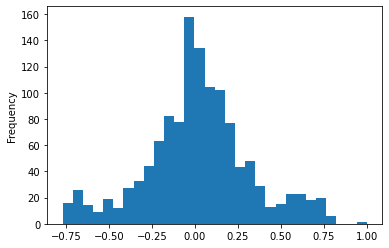

In [64]:
# Get the correlation matrix for indicators in 2016
corr_data = getAllIndicatorsPerCountryForYear(wdi_data, simplified_whr_data, 2016).corr()
hi_idx = corr_data.columns.get_loc('Life Ladder')

sorted_data = corr_data.sort_values(by='Life Ladder', ascending=False)

# plot the histogram of the correlation coefficients
sorted_data['Life Ladder'].plot.hist(bins=30)

n = len(sorted_data['Life Ladder'])
mean = sorted_data['Life Ladder'].mean()
std = sorted_data['Life Ladder'].std()
print("n: {}, mean: {}, standard deviation: {}".format(n, mean, std))


## Statistically Significant R-values
Given that the collection of correlation coefficients follow a relatively normal distribution we want a better way of figuring out concretely which correlations are statistically ignificant
- With `n = 1377, mean = 0.02705, std = 0.30845` and an alpha value of 0.05 (5%)
- We have that any correlation coefficients > **(0.02705 + 2 * 0.30845) = 0.643** and any coefficients < **(0.02705 - 2 * 0.30845) = -0.589** are significant enough to analyze

## Analyzing Some of the Strongest Correlations
- Given the above significant r-values we are able to see that all of the *Top 30 Correlation Coefficients* are statistically significant
- This should be more than enough for our analysis because we will be looking at selected factors rather than all of them

In [65]:
# Using the above metrics we create a list of the top 30
sorted_data.iloc[0:30, hi_idx:hi_idx+1]

,Life Ladder
Life Ladder,1.000000
"Life expectancy at birth, male (years)",0.802502
"Life expectancy at birth, total (years)",0.798338
Individuals using the Internet (% of population),0.785412
"Life expectancy at birth, female (years)",0.784476
"Survival to age 65, male (% of cohort)",0.768846
Employment in services (% of total employment) (modeled ILO estimate),0.765822
Access to clean fuels and technologies for cooking (% of population),0.759711
"Survival to age 65, female (% of cohort)",0.750665
"Employment in services, female (% of female employment) (modeled ILO estimate)",0.748443


### Some standout factors that correlate with increased happiness
- Increases in Life expectancy at birth, for men and women and total (in years)
- Increases in GNI (Gross National Income per capita) for the country
- Increases in % employment in a service based economy

### Analyzing the Negatively Correlated Data
- We see that just as with the positive correlations, the `Bottom 30 Most Negatively Correlated Indicators` are statistically significant, although in this case there is a more sudden drop in correlation as you move down the list

In [66]:
hi_idx = corr_data.columns.get_loc('Life Ladder')
corr_data.sort_values(by='Life Ladder', ascending=True).iloc[0:30, hi_idx:hi_idx+1]

,Life Ladder
Employment in agriculture (% of total employment) (modeled ILO estimate),-0.768773
"Employment in agriculture, male (% of male employment) (modeled ILO estimate)",-0.757722
Prevalence of anemia among children (% of children under 5),-0.751203
"Vulnerable employment, total (% of total employment) (modeled ILO estimate)",-0.743516
"Employment in agriculture, female (% of female employment) (modeled ILO estimate)",-0.736223
"Vulnerable employment, female (% of female employment) (modeled ILO estimate)",-0.734160
"Self-employed, total (% of total employment) (modeled ILO estimate)",-0.733061
"Vulnerable employment, male (% of male employment) (modeled ILO estimate)",-0.731811
"Self-employed, female (% of female employment) (modeled ILO estimate)",-0.728033
"Mortality rate, neonatal (per 1,000 live births)",-0.725100


### Some Standout factors for negatively correlating with happiness
- Increased % of total employment in agriculture
- Increased % of total employment that is vulnerable or self-employed
- Higher mortality rates for diseases/conditions/age groups.

### Lets take the top and bottom indicators for each correlation
- % of total employment in agriculture & Life expectancy at birth.
- Since these indicators have such high correlations we can fit them to a linear model.

 
-0.03756 x + 6.462


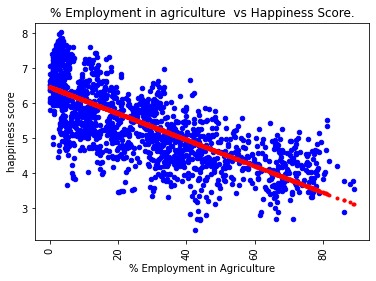

In [67]:
#Create a dataset combining simplified_whr with the proper indicator from wdi
eia_code = "SL.AGR.EMPL.ZS"
employmentInAgriculture=getAllForIndicator(wdi_data,simplified_whr_data, eia_code)

#Plot the data and fit a regression line.
ax=employmentInAgriculture.plot.scatter(x='indicator_value',xlabel=r"% Employment in Agriculture",y='Life Ladder',ylabel='happiness score', rot=90,color='b',title=r'% Employment in agriculture  vs Happiness Score.')
y=employmentInAgriculture['Life Ladder']
x=employmentInAgriculture['indicator_value']
z=np.polyfit(x,y,1)
eq=np.poly1d(z)
plt.plot(x,eq(x),'.',color='red')

#print the regression equation.
print(eq)


### Analysis
- It's easy to see that the strong negative correlation found in the tables above holds true when you plot the datapoints
- The equation for the line of best fit is `-0.03756 x + 6.462` meaning that with every % increase in employment in agriculture we can expect to see the happiness score decrease by `-.03756`

### Agriculture's Relationship with GDP and Happiness
There could be many reasons for this strong negative correlation. But we hypothesize that the reason may be that agriculture is actually negatively correlated with GDP. This is because most GDP comes from highly technical industries and it is very likely that places with a greater focus on agriculture have less of these industries to increase GDP. It also has been shown that typically, with developing countries, most people are either self-employed or employed in agriculture. A lot of the time this revolves around having a stable source of food, but also because with more developed countries, they have more advanced farming technologies that allow for a relatively small % of the population to produce enough food for the rest of the nation.

This falls in line with an analysis by ["Our World in Data"](https://ourworldindata.org/employment-in-agriculture#how-does-the-role-of-agriculture-change-as-economies-grow) and their look into various aspects surrounding agriculture around the world. Although not necessary, referencing external sources to verify and corroborate the results shows us that we are on the right track in our analysis, from both a conceptual point of view and in our math.

![% of total employment in agriculture](./agriculture-labor.png)
![Agricultural productivity](./agriculture-productivity.png)


### A quick hypothesis: Are you happier if you live longer?
Lets look at life expectancy (total) vs the happiness score.

 
0.1004 x - 1.718


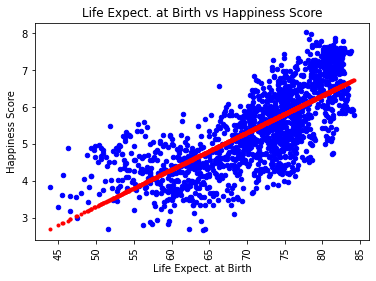

In [68]:
#Create a dataset combining simplified_whr with the proper indicator from wdi.
eia_code = "SP.DYN.LE00.IN"
lifeExpt=getAllForIndicator(wdi_data,simplified_whr_data, eia_code)

#Plot the data and fit a regression line.
ax=lifeExpt.plot.scatter(x='indicator_value',xlabel='Life Expect. at Birth',y='Life Ladder',ylabel='Happiness Score', rot=90,color='b',title=r'Life Expect. at Birth vs Happiness Score')
y=lifeExpt['Life Ladder']
x=lifeExpt['indicator_value']
z=np.polyfit(x,y,1)
eq=np.poly1d(z)
plt.plot(x,eq(x),'.',color='red')

#print the regression equation.
print(eq)

### Analysis
- It's easy to see that the strong positive correlation found in the graph above holds true when you plot the datapoints
- The equation for the line of best fit is `0.1004 x - 1.718` meaning that with every year increase in life expectancy we can expect to see the happiness score increase by `0.1004`.
- The reason for this correlation is likely a deep one. Places with high life expectancy are more prone to be more developed areas and therefore share many of the positive indicators such as GNI (Gross National Income) per capita, access to clean fuels and technologies for cooking, access to better healthcare, and many more. In this regard, we can consider life expectancy to be close to a blanket indicator for indicators that positively correlate with GDP and happiness.

### A quick hypothesis: Can money buy happiness?
Lets look at income per capita vs happiness score.

 
0.02337 x + 3.924


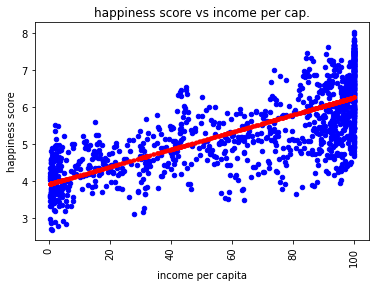

In [69]:
#Create a dataset combining simplified_whr with the proper indicator from wdi
ax=incomePerCap.plot.scatter(x='indicator_value',xlabel='income per capita',y='Life Ladder',ylabel='happiness score', rot=90,color='b',title='happiness score vs income per cap.')

#Plot the data and fit a regression line.
y=incomePerCap['Life Ladder']
x=incomePerCap['indicator_value']
z=np.polyfit(x,y,1)
eq=np.poly1d(z)
plt.plot(x,eq(x),'.',color='red')

#print the regression equation.
print(eq)

### Analysis
As it turns out. There is also a strong linear correlation between income per capita and happiness score. It is worth noting that the graph is less linear than its predecessors. It has 2 vertical lines at each end. One reason this could be the case is that income per capita is related to population and population has an upper limit at which a plateu occurs. Sure enough if you flip the x and y axis you will see a very similar plataeu. As for our hypothesis, can money buy happiness? We can not say. What we can say is that on average, for every increase in income per capita the happiness score increases by 0.02337, which does indicate that having increased disposible income does correlate with happiness, but that there also could be many additional confounding variables that contribute to this result.

## Conclusion
We hope that this tutorial was an insightful view not only into the data science pipeline, but also into the many ways you can confirm hypothesis and find correlations between datasets.

We also hope that this was a good showcase of all the ways you could represent and visualize data.

Graphing the most heavily correlated factors would also let us see in a more detailed way exactly how much the average moves with each unit that our indicator increased by. 

So was there certain indicators that could effect a nations happiness levels? Is there a way to build a perfect nation in which everyone is happy? Well, through our look into the World Happiness Index and the World Development Indicators from the World Bank, we were able that there is a strong relationship between the level of development a nation has achieved and their Happiness Scores. Most of the factors found in both the most positively and negatively correlated indicators are tied to a nations level of development.

Exceptions do exist, like China and Russia being developed yet having relatively low Happiness Scores, but it was shown through our analysis that nevertheless GDP, and associated indicators of country development (like Gross National Income, Education attainment/participation, Mortality Rates, Labor Force distribution/participation, Job Stability) largely determine how happy a country is.

For more info about how the happiness score is calculated, or about the research done into the world development indicators feel free to explore the links below:
https://datatopics.worldbank.org/world-development-indicators/
 
https://worldhappiness.report/ed/2019/

For information about the way correlation matrices are calculated in Pandas

https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance - Uses Welfords Algorithm